# Looking into `revision.csv`

## Goals
1. Cleaning and understanding `revision.csv`, from [**popular-3k-python dataset**](https://docs.softwareheritage.org/devel/swh-dataset/graph/dataset.html#popular-3k-python). Hopefully will be able to:
    * determine if there are any irregularities/anomolies in the data,
    * locate and extract commit hashes that fix known software bugs,
    * and see which software bugs are more prevalent and severe.
    <br><br>
2. Cross-reference commit hashes (ones that fix CVE's) with NVD CVE-dataset.

Reading in data from `revision.csv` and selecting appropriate columns. Download `revision.csv` [here](https://annex.softwareheritage.org/public/dataset/graph/latest/popular-3k-python/sql/revision.csv.gz).

In [14]:
import pandas as pd
import datetime as dt
import re
import matplotlib.pyplot as plt

In [2]:
rev_df = pd.read_csv('../data/popular-3k-python/revision.csv', header=None)
rev_df.columns = ['id', 'date', 'date_offset', 'committer_date', 'committer_date_offset', 'type', 'directory', 'message', 'author', 'committer']
rev_df = rev_df[['id', 'date', 'message']]
rev_df

,id,date,message
0,\x01714ff5fd94a846f7dc3456a52e6f2dcd36ca0b,2015-04-02T01:11:50.000Z,\x496d706c656d656e74206461736b2e61727261792e74...
1,\x01d76a45b817be788eab3e27a93e41c74a6d8957,2010-08-14T17:15:31.000Z,\x436f6e7665727420746f207370616365732e0a
2,\x03ac0bf5d03af97bc7dc7c5aa67d8ee346f8cd1c,2013-09-27T17:02:55.000Z,\x4d657267652070756c6c207265717565737420233438...
3,\x05c9110ba2615d42af41a77138bc62dd18278320,2011-10-25T20:11:52.000Z,\x4d657267652070756c6c207265717565737420233136...
4,\x06de8d8e88d5b6311ea3feae369c85d157c9dfe3,2017-10-31T20:29:21.000Z,\x5570646174652070617463682073657420310a0a5061...
...,...,...,...
5188989,\xfb5183dd25cb0bde1f8a1da20d07b940883f8f17,2012-10-16T02:18:13.000Z,\x466978657320666f7220756e61727920616e6420696e...
5188990,\xfc05c476f53b6aa6188070601fada55a6677ef01,2017-10-23T20:49:07.000Z,\x526576657274202255706461746520434f4e54524942...
5188991,\xfcd97879e3cd57a15f91db81ff88da7c6c114b98,2013-08-27T14:12:35.000Z,\x496d70726f76652053454f20746f6f6c732043535320...
5188992,\xfd71164472400e8f373a1d9de7d6e92a6aa8be07,2017-05-23T21:18:40.000Z,\x55706461746520434f4e545249425554494e472e6d64...


## Cleaning up column data
* remove leading "`\x`" from **`id`** column
* convert **`date`** column from `string` to `datetime` object
* remove leading "`\x`" from **`message`** column and convert into readable text

In [3]:
rev_df['id'] = rev_df['id'].apply(lambda x: x[2:])
rev_df['date'] = rev_df['date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.000Z'))
rev_df['message'] = rev_df['message'].apply(lambda x: bytes.fromhex(x[2:]).decode(encoding='ISO-8859-1'))
rev_df

,id,date,message
0,01714ff5fd94a846f7dc3456a52e6f2dcd36ca0b,2015-04-02 01:11:50,"Implement dask.array.take\n\nIn principle, we ..."
1,01d76a45b817be788eab3e27a93e41c74a6d8957,2010-08-14 17:15:31,Convert to spaces.\n
2,03ac0bf5d03af97bc7dc7c5aa67d8ee346f8cd1c,2013-09-27 17:02:55,Merge pull request #4887 from cpcloud/groupby-...
3,05c9110ba2615d42af41a77138bc62dd18278320,2011-10-25 20:11:52,Merge pull request #162 from gabrielhurley/use...
4,06de8d8e88d5b6311ea3feae369c85d157c9dfe3,2017-10-31 20:29:21,Update patch set 1\n\nPatch Set 1: Presubmit-V...
...,...,...,...
5188989,fb5183dd25cb0bde1f8a1da20d07b940883f8f17,2012-10-16 02:18:13,Fixes for unary and indexing operations.\n
5188990,fc05c476f53b6aa6188070601fada55a6677ef01,2017-10-23 20:49:07,"Revert ""Update CONTRIBUTING.md""\n\nThis revert..."
5188991,fcd97879e3cd57a15f91db81ff88da7c6c114b98,2013-08-27 14:12:35,Improve SEO tools CSS across themes\n\nbzr rev...
5188992,fd71164472400e8f373a1d9de7d6e92a6aa8be07,2017-05-23 21:18:40,Update CONTRIBUTING.md\n\nFixing broken issues...


In [4]:
for index, row in rev_df.head().iterrows():
    print('index:', index, '\nid:', row['id'], '\ndate:', row['date'], '\nmessage:', row['message'])

index: 0 
id: 01714ff5fd94a846f7dc3456a52e6f2dcd36ca0b 
date: 2015-04-02 01:11:50 
message: Implement dask.array.take

In principle, we could use a fast path here instead of invoking normal
indexing (like np.take itself), but it didn't seem work the trouble for now.

index: 1 
id: 01d76a45b817be788eab3e27a93e41c74a6d8957 
date: 2010-08-14 17:15:31 
message: Convert to spaces.

index: 2 
id: 03ac0bf5d03af97bc7dc7c5aa67d8ee346f8cd1c 
date: 2013-09-27 17:02:55 
message: Merge pull request #4887 from cpcloud/groupby-blacklist

API: disable to_csv and friends on GroupBy objects
index: 3 
id: 05c9110ba2615d42af41a77138bc62dd18278320 
date: 2011-10-25 20:11:52 
message: Merge pull request #162 from gabrielhurley/user_tenant_fixes_master

Fixes for LP bugs 879626, 879633, and 879641.
index: 4 
id: 06de8d8e88d5b6311ea3feae369c85d157c9dfe3 
date: 2017-10-31 20:29:21 
message: Update patch set 1

Patch Set 1: Presubmit-Verified+1

=== Finished presubmit run: L47500000116329323 ===

Status: https:

## List which days have the most commits

In [6]:
rev_df['date'].value_counts().head(10)

2017-05-23 21:18:40    262161
2017-10-23 20:49:07    262152
2016-04-08 10:44:50       216
2004-08-17 15:34:28       156
2014-06-02 09:05:46       148
2015-12-23 16:26:14       145
2004-01-30 00:01:24       144
2018-05-13 14:36:58       137
2014-06-20 19:00:00       130
2016-12-09 05:03:32       114
Name: date, dtype: int64

Hmmm... over 200,000 commits at once

## List number of commits by year

In [8]:
rev_df.groupby(rev_df['date'].dt.year)['date'].count().reset_index(name='count')

,date,count
0,1980,2
1,1988,6
2,1989,3
3,1990,228
4,1991,2952
5,1992,3453
6,1993,4794
7,1994,4593
8,1995,5529
9,1996,6957


In [9]:
rev_df[(rev_df['date'] < '2005-07-11')].head()

,id,date,message
31,423228de758fa037653cff43f2c8e1408c79f576,2002-07-25 16:01:12,Extended socket.htonl and ntohl to accept long...
68,7ddde32ead1b704be807937fa0947e3c57ee51ac,2004-11-20 23:54:33,Implement the X86 JIT interfaces\n\n\ngit-svn-...
127,e89ddb296bf1795d71b500f3a65313722a5e7ffe,1994-01-18 10:09:50,Fix copyright -- 1994 instead of 1004!\n
131,f2038c83b10551c942574c831cb7fd9eaab6ca57,2000-03-31 16:39:02,Added some clarifications to pyexpat.\n
157,1663f3383849968415d29965ef9bfdf5aac4d358,2001-09-29 23:49:51,Tweak btree page split logic so that when spli...


Git was released on July 7, 2005. Therefore, any data before this timestamp is more than likely related to Unix or Debian/Linux.

In [10]:
for i in [31, 68, 127, 131, 157]:
    print('id:', rev_df.loc[i]['id'], '\ndate:', rev_df.loc[i]['date'], '\nmessage:', rev_df.loc[i]['message'])

id: 423228de758fa037653cff43f2c8e1408c79f576 
date: 2002-07-25 16:01:12 
message: Extended socket.htonl and ntohl to accept longs.

Fixes SF bug #568322.

The code should raise an OverflowError if the long is > 32 bits, even
on platforms where sizeof(long) > 4.

id: 7ddde32ead1b704be807937fa0947e3c57ee51ac 
date: 2004-11-20 23:54:33 
message: Implement the X86 JIT interfaces


git-svn-id: https://llvm.org/svn/llvm-project/llvm/trunk@18067 91177308-0d34-0410-b5e6-96231b3b80d8

id: e89ddb296bf1795d71b500f3a65313722a5e7ffe 
date: 1994-01-18 10:09:50 
message: Fix copyright -- 1994 instead of 1004!

id: f2038c83b10551c942574c831cb7fd9eaab6ca57 
date: 2000-03-31 16:39:02 
message: Added some clarifications to pyexpat.

id: 1663f3383849968415d29965ef9bfdf5aac4d358 
date: 2001-09-29 23:49:51 
message: Tweak btree page split logic so that when splitting a page that is
rightmost on its tree level, we split 2/3 to the left and 1/3 to the
new right page, rather than the even split we use elsewher

## List number of commits by month and year for the last 5 years

In [11]:
rev_df.groupby([rev_df['date'].dt.year, rev_df['date'].dt.month])['date'].agg(['count'])[-59:]

count
date date        
2014 1      48083
     2      45449
     3      49187
     4      43956
     5      40108
     6      43792
     7      50798
     8      48123
     9      48101
     10     48170
     11     45068
     12     42315
2015 1      52741
     2      51504
     3      57491
     4      54256
     5      53002
     6      58515
     7      57203
     8      58416
     9      56505
     10     55803
     11     52701
     12     57416
2016 1      57895
     2      61027
     3      68996
     4      59119
     5      58576
     6      65650
     7      62660
     8      66167
     9      59543
     10     52228
     11     52313
     12     53407
2017 1      59367
     2      57730
     3      66892
     4      55948
     5     317254
     6      54220
     7      51560
     8      55892
     9      51760
     10    314712
     11     51830
     12     45291
2018 1      53984
     2      52776
     3      56151
     4      48596
     5      52213
     6      49970
     7      45902
     8      43810
     9      22436
     12         3
2019 3          4

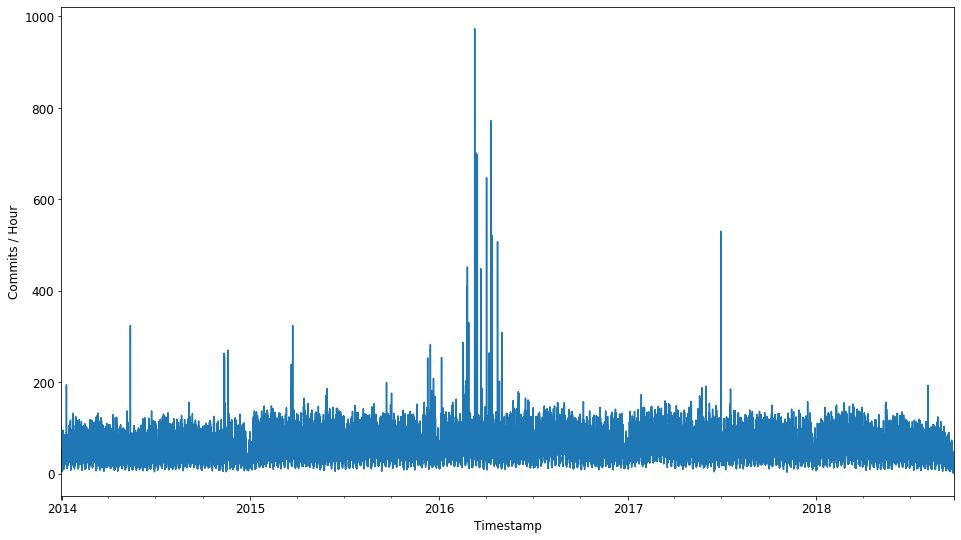

In [15]:
plt.rcParams["figure.figsize"] = [16,9]
plt.rcParams.update({'font.size': 12})

commits_per_hour = rev_df[((rev_df['date'] != '2017-05-23') | (rev_df['date'] != '2017-10-23')) & ((rev_df['date'] > '2013-12-31') & (rev_df['date'] < '2018-10-01'))]['date'].value_counts().resample('H').apply('count')
commits_per_hour.plot()
plt.ylabel('Commits / Hour')
plt.xlabel('Timestamp')
plt.show()

Showing data from last 5 years roughly 
* January 1, 2014 - September 30, 2018
* Excluding May 23, 2017 and September 10, 2017 (possible anomalies?)

## Extract commits that _directly_ address fixing a CVE in the commit message
* pulled out commit messages containing: "Fixed CVE", "fixed CVE", "Fix CVE", "fix CVE", "Fixes CVE", "fixes CVE"

In [16]:
cve_fixes = rev_df[(rev_df['message'].str.contains("Fixed CVE")) | (rev_df['message'].str.contains("fixed CVE")) | (rev_df['message'].str.contains("Fix CVE")) | (rev_df['message'].str.contains("fix CVE")) | (rev_df['message'].str.contains("Fixes CVE")) | (rev_df['message'].str.contains("fixes CVE"))]

In [17]:
for index, row in cve_fixes.head().iterrows():
    print('index:', index, '\nid:', row['id'], '\ndate:', row['date'], '\nmessage:', row['message'])

index: 3270 
id: 45acd6d836895a4c36575f48b3fb36a3dae98d19 
date: 2016-10-17 16:14:49 
message: [1.9.x] Fixed CVE-2016-9014 -- Validated Host header when DEBUG=True.

This is a security fix.

index: 28773 
id: 964c61ce79f6748ff8c583e2eb12ec54082bf188 
date: 2014-02-09 08:40:59 
message: Fix CVE-2014-0012

Add checks for the per-user temporary directory.  If it already exists, make
sure that it:
- is owned by the current user
- is directory
- has expected permissions

This commit also fixes:
- nt -> n typo pointed out in the review of acb672b
- replace 448 with stat.S_IRWXU when setting directory mode

Signed-off-by: Armin Ronacher <armin.ronacher@active-4.com>

index: 83145 
id: e3e119acdb6680d8a6927ad1fce89266dd6ecb85 
date: 2017-12-01 17:54:21 
message: bpo-30657: Fix CVE-2017-1000158

Fixes possible integer overflow in PyBytes_DecodeEscape.

Co-Authored-By: Jay Bosamiya <jaybosamiya@gmail.com>

index: 97944 
id: 71627f3d1964ef9831ea7997d2f4ac5617c718cc 
date: 2013-02-13 21:20:01 
mes

## Extract commit ids that fix CVE's 

In [18]:
commit_ids = cve_fixes['id']

## Extract mentioned CVE's

In [19]:
cve_list = []

for index, row in cve_fixes.iterrows():
    msg = cve_fixes['message'][index]
    cve = (re.search('CVE-[0-9][0-9][0-9][0-9]-([0-9][0-9][0-9][0-9]+)', msg)).group()
    cve_list.append(cve)
    
cve_series = pd.Series(cve_list)

In [20]:
len(cve_series.unique())

37

Of the 99 commits that fixed a CVE, only 37 are unique

In [21]:
cve_series.value_counts()

CVE-2013-4238       10
CVE-2017-7234        5
CVE-2017-11610       5
CVE-2018-14574       4
CVE-2017-1000158     4
CVE-2018-7537        4
CVE-2016-9013        4
CVE-2016-9014        4
CVE-2018-7536        4
CVE-2017-12794       3
CVE-2018-6188        3
CVE-2013-1977        3
CVE-2015-5162        3
CVE-2016-2513        3
CVE-2016-2512        3
CVE-2014-3470        2
CVE-2013-2099        2
CVE-2014-3506        2
CVE-2014-0012        2
CVE-2007-4965        2
CVE-2014-0221        2
CVE-2016-7401        2
CVE-2013-1424        2
CVE-2012-2135        2
CVE-2008-1721        2
CVE-2014-3505        2
CVE-2017-0910        2
CVE-2014-3507        2
CVE-2014-1932        2
CVE-2016-5026        2
CVE-2010-3864        1
CVE-2009-5023        1
CVE-2017-14158       1
CVE-2013-1445        1
CVE-2013-4347        1
CVE-2013-0255        1
CVE-2010-1633        1
dtype: int64

Here we can see that **CVE-2013-4238** is the most referenced software bug. This bug deals with a function that does not properly handle a '\0' character. The NVD listed it as having a severity rating of 4.3 (medium). More inforation can be found [here](https://nvd.nist.gov/vuln/detail/CVE-2013-4238).